In [1]:
from a_mps import *
from b_model import *
from c_tebd import * #calc_U_bonds, update_bond, run_iTEBD
from tfi_exact import *#infinite_gs_energy

import scipy as sp
import matplotlib.pyplot as plt

**Exercise 11.1**

**(b)**

In [2]:
def imaginary_iTEBD(L, J, g):
    print("infinite TEBD, (imaginary time evolution)")
    print("L={L:d}, J={J:.1f}, g={g:.2f}".format(L=L, J=J, g=g))
    model = iTFIModel(L, J, g)
    psi = init_spinup_iMPS(L)
    for dt in [0.1, 0.01, 0.001, 1.e-4, 1.e-5]:
        U_bonds = calc_U_bonds(model, dt)
        run_iTEBD(psi, U_bonds, N_steps=500, chi_max=30, eps=1.e-10)
        E = model.energy(psi)
        print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
    print("final bond dimensions: ", psi.get_chi())
    if L < 20:  # for small systems compare to exact diagonalization
        E_exact = infinite_gs_energy(J, g)
        print("Exact diagonalization: E = {E:.13f}".format(E=E_exact))
        print("relative error: ", abs((E - E_exact) / E_exact))
    return E, psi, model

In [3]:
E, psi, model = imaginary_iTEBD(L=2, J=1, g=1)

infinite TEBD, (imaginary time evolution)
L=2, J=1.0, g=1.00
dt = 0.10000: E = -1.2689318050868
dt = 0.01000: E = -1.2728170781934
dt = 0.00100: E = -1.2731936013346
dt = 0.00010: E = -1.2732311735223
dt = 0.00001: E = -1.2732349328054
final bond dimensions:  [30, 30]
Exact diagonalization: E = -1.2732395447352
relative error:  3.6222011458533383e-06


**(c)**

In [4]:
def transfermatrix(mps):
    
    assert mps.L == 2

    T = np.tensordot(mps.Bs[0], mps.Bs[1], axes=[2, 0]) # v0L i0 [v0R], [v1L] i1 v1R
    T = np.tensordot(T, T.conj(), axes=[[1, 2], [1, 2]]) # v0L [i0] [i1] v1R, v0L' [i0'] [i1'] v1R'
    T = T.transpose([0, 2, 1, 3]) # v0L v0L' v1R v1R'
    T = T.reshape(T.shape[0]*T.shape[1], T.shape[2]*T.shape[3]) # v0L*v0L' v1R*v1R'

    return T

**(d)**

In [5]:
def imaginary_iTEBD(L, J, g):
    model = iTFIModel(L, J=J, g=g)
    psi = init_spinup_iMPS(L)
    for dt in [0.1, 0.01, 0.001, 1.e-4, 1.e-5]:
        U_bonds = calc_U_bonds(model, dt)
        run_iTEBD(psi, U_bonds, N_steps=500, chi_max=30, eps=1.e-10)
        E = model.energy(psi)
    return E, psi, model

In [6]:
L=2
J=1
g_list = np.arange(0.5, 1.5 + 0.1, 0.1)
max = 3

Λ = np.zeros((max, len(g_list)))
for i, g in enumerate(g_list):
    _, psi, _ = imaginary_iTEBD(L, J, g)
    λs, _ = sp.sparse.linalg.eigs(transfermatrix(psi), max, which='LM')
    Λ[:, i] = np.abs(λs)

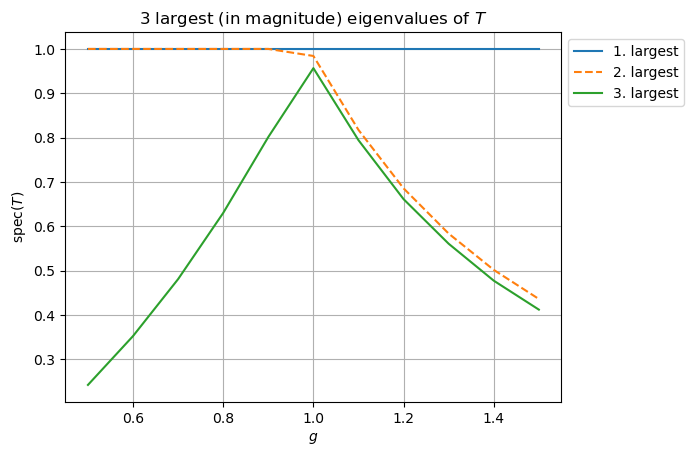

In [7]:
fig, ax = plt.subplots(1, 1)
for k in range(max):
    ax.plot(g_list, Λ[k, :], '--' if k==1 else '-', label='%d. largest'%(k+1))
ax.set_xlabel('$g$'), ax.set_ylabel('spec($T$)'), ax.set_title('3 largest (in magnitude) eigenvalues of $T$'), ax.grid(), ax.legend(bbox_to_anchor=(1.0, 1.0));